# Hand-calculated derivative rules: Error prone

Hand-computation of derivatives of complicated functions involving vectors and matrices is **error-prone**, and is a common source of bugs when performing numerical optimization, root-finding, sensitivity-analysis, etcetera.

The ideal alternative is to use **automatic differentiation (AD)**:
* AD lets software/compilers perform the derivatives for you.  This is extremely reliable and, with modern AD software, can be very efficient.
* Unfortunately, there is still lots of code, e.g. code calling external libraries in other languages, that AD tools can't comprehend.
* And there are other cases where AD "needs help" — for example, if you are computing an answer *approximately* (e.g. solving a nonlinear equation by Newton's method), AD can waste a lot of effort trying to *exactly differentiate the error* in your approximation.   Often, you can compute the approximate answer (to the same accuracy) much more efficiently.
* Even in cases where AD falls down, often you only need to give it a **little help**: define a differentiation rule for a *small piece* of your program and let AD handle the rest.  In Julia, this is done with by defining a ["ChainRule"](https://github.com/JuliaDiff/ChainRulesCore.jl), and in Python autograd/JAX it is done by defining a custom "vJp" (row-vector—Jacobian product) and/or "Jvp" (Jacobian–vector product).

If you do have to work out your own derivative rule, you *really* need to **check** it against something "brute force" and hard to get wrong.  The usual candidate is…

# Finite-difference approximations: Easy version

The simplest way to check a derivative is to recall that the definition of a differential:
$$
df = f(x+dx) - f(x) = f'(x) dx
$$
came from dropping higher-order terms from a small but finite difference:
$$
\delta f = f(x+\delta x) - f(x) = f'(x) \delta x + o(\Vert \delta x \Vert)
$$
So, we can just compare the **finite difference** $\boxed{f(x+\delta x) - f(x)}$ to our **(directional) derivative operator** $f'(x) \delta x$ (i.e. the derivative in the direction $\delta x$).

$f(x+\delta x) - f(x)$ is also called a **forward difference** approximation.  We'll look at other possibilities below.

* The antonym of a forward diffence is a **backward difference** approximation $f(x) - f(x - \delta x) \approx f'(x) \delta x$ … if you just want to compute a derivative, there is not much practical distinction between forward and backward differences.  The distinction becomes more important when discretizing (approximating) differential equations.

* Finite-difference approximations come in many forms, but they are generally a **last resort** in cases where it's too much effort to work out an analytical derivative and AD fails.  But they are also useful to **check** your analytical derivatives and to quickly **explore**.

## example: f(A)=A²

Let's try it for $f(A) = A^2$ (a matrix-valued function of a square matrix $A \in \mathbb{R}^{m\times m}$).

First, we'll do it by hand via the product rule:

$$
df = A dA + dA A
$$
i.e. $f'(A)$ is the **linear operator** $\boxed{f'(A)[\delta A] = A \delta A + \delta A A}$.  This is **≠ 2AδA** because because **A and δA do not commute** in general.

Let's check it against a finite difference.   We'll try it for a *random* input A and a *random small* perturbation $\delta A$:

In [1]:
f(A) = A^2

A = randn(4,4) # 4×4 matrix with Gaussian random (bell curve) entries of magnitude ~ 1 (std. dev = 1)

4×4 Matrix{Float64}:
 0.788153  -0.447733  -1.719     -1.72874
 0.764881   0.144171  -0.92426    0.950178
 0.302174  -0.196347  -0.647888   0.249025
 0.637951  -0.652182   0.834098  -0.50141

In [2]:
dA = randn(4,4) * 1e-8 # a small random perturbation ~ 10⁻⁸

4×4 Matrix{Float64}:
  5.32793e-9   -1.62019e-10   6.85652e-9  -1.10411e-8
 -1.58104e-8   -1.07715e-8    1.28671e-8  -7.68447e-9
  1.12579e-8    1.46557e-9   -1.8312e-8    5.37786e-9
  8.26803e-11   2.46202e-9   -1.09485e-8   2.18978e-8

In [3]:
approx = f(A + dA) - f(A) # finite difference

4×4 Matrix{Float64}:
 -9.11364e-9   1.36525e-9  2.7388e-8   -5.44828e-8
 -3.0245e-8    7.31907e-9  3.60092e-8   3.04379e-8
  5.33235e-9  -3.01148e-9  4.32611e-9  -2.51848e-8
  3.56686e-8  -4.90415e-9  9.13883e-9  -2.00359e-8

In [4]:
exact = A*dA + dA*A # exact directional derivative (linearization)

4×4 Matrix{Float64}:
 -9.11364e-9   1.36525e-9  2.7388e-8   -5.44828e-8
 -3.0245e-8    7.31907e-9  3.60092e-8   3.04379e-8
  5.33236e-9  -3.01148e-9  4.32611e-9  -2.51848e-8
  3.56686e-8  -4.90415e-9  9.13883e-9  -2.00359e-8

In [5]:
2A*dA # wrong! matrices don't commute

4×4 Matrix{Float64}:
 -1.64343e-8  -4.16089e-9   1.00097e-7  -1.04723e-7
 -1.70616e-8  -1.38417e-9   2.7243e-8    1.25666e-8
 -5.11794e-9   3.45915e-9   1.73663e-8   2.82707e-10
  4.61179e-8   1.38192e-8  -2.76037e-8  -1.70522e-8

In [6]:
2A*dA - approx

4×4 Matrix{Float64}:
 -7.32063e-9  -5.52614e-9   7.27091e-8  -5.02407e-8
  1.31833e-8  -8.70324e-9  -8.76618e-9  -1.78713e-8
 -1.04503e-8   6.47063e-9   1.30402e-8   2.54675e-8
  1.04493e-8   1.87233e-8  -3.67426e-8   2.98371e-9

To be more quantitative, we might compute the "norm" $\Vert \text{approx} - \text{exact} \Vert$, which we want to be small.   But small **compared to what?**   The natural answer is **small compared to the correct answer**.  This is called the [relative error](https://en.wikipedia.org/wiki/Approximation_error) (or "fractional" error):
$$
\text{relative error} = \frac{\Vert \text{approx} - \text{exact} \Vert}{\Vert \text{exact}\Vert}
$$
Here, $\Vert \cdot \Vert$ is a [norm](https://en.wikipedia.org/wiki/Norm_(mathematics)), like the length of a vector. In Julia, the `LinearAlgebra` package provides a `norm` function, and we can use that to define a relative error:

In [7]:
using LinearAlgebra

relative_error(approx, exact) = norm(approx - exact) / norm(exact)

relative_error (generic function with 1 method)

Let's try it on our case above:

In [8]:
relative_error(approx, exact)

1.0537841489905694e-8

Pretty good — we are matching to **about eight significant digits**!

Getting a good match for a random input and a random small displacement isn't a proof of correctness, but it is always a good thing to check.   This kind of randomized comparison will almost always **catch major bugs** where you have calculated the symbolic derivative incorrectly, like our $2AdA$ example:

In [9]:
relative_error(2A*dA, exact)

1.0939548290083552

Here, for our buggy derivative, the relative error was **close to 50%**.

### aside: norm of a matrix?

Wait, what do we mean by the norm $\Vert A \Vert$ of a matrix $A$?

The ordinary Euclidean ("L2") norm of a column-vector $x \in \mathbb{R}^n$ is $\Vert x \Vert = \sqrt{x^T x} = \sqrt{\sum_i x_i^2}$.

For a matrix, the natural analogue is the **sqrt of the sum of the squares of the entries**.  This is called the [Frobenius norm](https://mathworld.wolfram.com/FrobeniusNorm.html), and is what `norm(A)` does in Julia by default.

In [10]:
using Symbolics

@variables m11 m12 m13 m21 m22 m23
M = [m11 m12 m13
     m21 m22 m23]

2×3 Matrix{Num}:
 m11  m12  m13
 m21  m22  m23

In [11]:
norm(M)

sqrt(abs2(m11) + abs2(m12) + abs2(m13) + abs2(m21) + abs2(m22) + abs2(m23))

(`abs2(x)` in Julia is the squared absolute value $|x|^2$.)

But we can write this in linear algebra notation!

Recall that the (Euclidean) "inner product" of two matrices is $\text{tr}(B^T A)$.   Then we can define the Frobenius norm of a matrix as the sqrt of the dot product with itself!

$$
\Vert A \Vert_F = \sqrt{\text{trace}(A^T A)}
$$

In [12]:
norm(A)

3.393988998622872

In [13]:
sqrt(tr(A'A))

3.393988998622872

In [14]:
sqrt(sum(abs2, A))

3.393988998622872

In [15]:
sqrt(sum(A[i,j]^2 for i = 1:4, j = 1:4))

3.393988998622872

(There are also other ways to define a norm of matrix, most famously by "induced norms", but we will stick with the Frobenius norm here.)

# Accuracy of finite differences

How accurate is our finite-difference approximation above?  How should we choose the size of δx?

Let's try our example $f(A) = A^2$ above, and plot the relative error as a function of $\Vert \delta A \Vert$ as we scale $\delta A$ by a factor $s$, making it larger or smaller.

In [16]:
using Plots # load a plotting package; there are several to choose from in Julia; this is a popular one
using LaTeXStrings # makes it easy to put LaTeX equations in L"..." strings

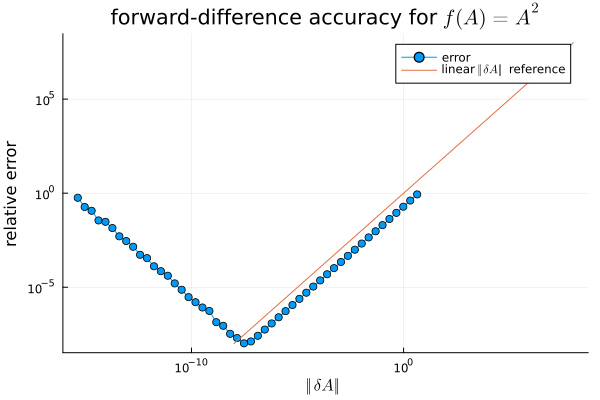

In [17]:
s = 10 .^ range(-8,8,50)
errors = [relative_error(f(A+s*dA)-f(A), exact*s) for s in s]
plot(s * norm(dA), errors, xaxis=:log, yaxis=:log, markershape=:circle,
     title = L"forward-difference accuracy for $f(A)=A^2$", xlabel=L"\Vert \delta A\Vert", ylabel="relative error",
     label = "error")
plot!(s, s, label=L"linear $\Vert \delta A\Vert$ reference")

We observe two main features:

* The relative error decreases *linearly* with $\Vert \delta A \Vert$.  This is called **first-order accuracy**.  Why?
* When δA gets too small, the error *increases*.  Why?

## Order of accuracy

If the relative error scales with $\Vert \delta A \Vert^n$, we call the approximation **n-th order accurate**.  For forward differences, here, the order is **n=1**.  Why?

For any $f(x)$ with a nonzero second derivative (think of the Taylor series), we have
$$
    f(x + \delta x) = f(x) + f'(x) \delta x + (\text{terms proportional to }\Vert \delta x \Vert^2) + \underbrace{o(\Vert \delta x \Vert^2)}_\text{i.e. higher-order terms}
$$

That is, the terms we *dropped* in our forward-difference approximations are proportional to $\Vert \delta x\Vert^2$.  But that means that the **relative error is linear**:
$$
\begin{align}
  \text{relative error} &= \frac{\Vert f(x+\delta x) - f(x) - f'(x) \delta x \Vert}{\Vert f'(x) \delta x \Vert} \\
   &= \frac{(\text{terms proportional to }\Vert \delta x \Vert^2) + o(\Vert \delta x \Vert^2)}{\text{proportional to }\Vert \delta x \Vert} = (\text{terms proportional to }\Vert \delta x \Vert) + o(\Vert \delta x \Vert)
\end{align}
$$

This source of error in a finite-difference approximation, due to **inherent** error in the formula for **non-infinitesimal** $\delta x$, is called **truncation error**.

## Roundoff error

The reason why the error *increased* for very small $\delta A$ was due to **roundoff errors**.  The computer only stores a **finite number of significant digits** (about 15 decimal digits) for each real number and rounds off the rest on each operation — this is called [floating-point arithmetic](https://en.wikipedia.org/wiki/Floating-point_arithmetic).

If δx is too small, then the difference $f(x+\delta x) - f(x)$ gets rounded off to zero (some or all of the *significant digits cancel*).  This is called [catastrophic cancellation](https://en.wikipedia.org/wiki/Catastrophic_cancellation).

Let's compute the derivative of $\sin(x)$ at $x=1$ with finite differences.   For a scalar $f(x)$, we have $f(x+\delta x) - f(x) \approx f'(x) \delta x$, or equivalently:

$$
f'(x) = \frac{f(x+\delta x) - f(x)}{\delta x} + \underbrace{O(\delta x)}_{\text{terms proportional to }|\delta x|\text{ or smaller}}
$$

(This is the usual way you see a forward difference approximation written, but it only works when $\delta x$ is a scalar.)

In [18]:
dx = 1e-5
(sin(1 + dx) - sin(1))/dx

0.5402980985058647

In [19]:
cos(1) # correct answer

0.5403023058681398

In [20]:
relative_error((sin(1 + dx) - sin(1))/dx, cos(1))

7.787052228587771e-6

So far, so good.  For $\delta x = 10^{-5}$, we got about 5–6 significant digits correct.  Now let's make $\delta x$ much smaller, $\delta x = 10^{-100}$:

In [21]:
dx = 1e-100
(sin(1 + dx) - sin(1))/dx

0.0

What happened?   The computer can represent small numbers just fine, because floating-point corresponds to "scientific notation":

In [22]:
1e-100

1.0e-100

But look at this:

In [23]:
1 + 1e-100

1.0

The correct answer would be
$$
1 + 10^{-100} = 1.\underbrace{000000\cdots000000}_{\text{99 zeros}}1
$$
but the computer only stores about 15 decimal digits (by default … you can ask for more, at the expense of speed), so it rounds this to $1.0$.

Hence, our finite difference gave zero.

Even if we do something less extreme, we have problems.   This looks okay:

In [24]:
dx = 1e-13
1 + dx

1.0000000000001

because the computer has enough digits, right?  But compare:

In [25]:
sin(1 + dx)

0.8414709848079505

In [26]:
sin(1)

0.8414709848078965

They only differ in the **last 4 significant digits stored**.  So when you subtract them, you only have **4 digits** left:

In [27]:
relative_error((sin(1 + dx) - sin(1))/dx, cos(1))

0.001358343083756518

and the error for $\delta x = 10^{-13}$ is now $10^{-3}$!!

### Machine precision and a rule of thumb for finite differences

The number of significant digits stored by the computer is expressed by the [machine epsilon](https://en.wikipedia.org/wiki/Machine_epsilon) $\epsilon$.  Essentially, for a number $x$, the number $\epsilon |x|$ is the size of the *last significant digit* of $x$, so that the *next* floating-point nubmer is $\approx x (1+\epsilon)$. 

$\epsilon$ is returned by the [`eps()` function in Julia](https://docs.julialang.org/en/v1/base/base/#Base.eps-Tuple{Type{%3C:AbstractFloat}}).

In [28]:
ϵ = eps()

2.220446049250313e-16

This tells us that the computer stores about 15–16 decimal digits (in the default ["double precision"](https://en.wikipedia.org/wiki/Double-precision_floating-point_format)).  It's not an exact number of *decimal* digits because it's actually 52 **binary digits** $1.\underbrace{ddd\cdots ddd}_{52} \times 2^\mathrm{exponent}$:

In [29]:
2^-52

2.220446049250313e-16

A **very crude** rule of thumb for finite differences is to choose $\delta x$ to correspond to about **half the significant digits** of $x$, i.e.
$$
\Vert \delta x \Vert \approx \sqrt{\varepsilon} \Vert x \Vert
$$
That is, if $x$ is of order $\sim 1$, then $\delta x$ should be of order $\sqrt{\epsilon} \approx 10^{-8}$:

In [30]:
√ϵ

1.4901161193847656e-8

Indeed we saw above with $f(A) = A^2$ that this was about where we saw a minimum error from the finite difference — it "balanced" the truncation and roundoff errors.  We can see something similar for the derivative of $\sin x$:

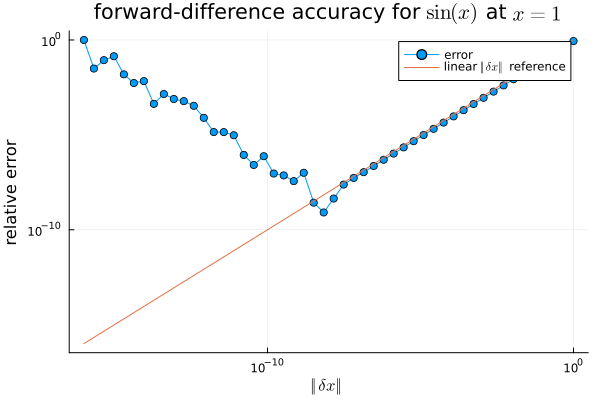

In [31]:
s = 10 .^ range(-16,0,50)
errors = [relative_error((sin(1+s)-sin(1))/s, cos(1)) for s in s]
plot(s, errors, xaxis=:log, yaxis=:log, markershape=:circle,
     title = L"forward-difference accuracy for $\sin(x)$ at $x=1$", xlabel=L"\Vert \delta x\Vert", ylabel="relative error",
     label = "error")
plot!(s, s, label=L"linear $\Vert \delta x\Vert$ reference")

Yup, the minimum is around $\approx 10^{-8}$.

## Higher-order finite-difference approximations

Of course, there are other finite-difference formulas.  For example, the most famous is the **centered-difference** formula:

$$
f'(x) \delta x \approx \frac{f(x+\delta x) - f(x - \delta x)}{2} + O(\Vert \delta \Vert^3)
$$

which for scalar $\delta x$ can be written in the more familiar form


$$
f'(x) \approx \frac{f(x+\delta x) - f(x - \delta x)}{2\delta x} + O(\Vert \delta \Vert^2)
$$

This formula is **second-order accurate**: the error in the derivative is proportional to $\Vert \delta \Vert^2$ (assuming a thrice-differentiable function).   You can show this by plugging the Taylor series for $f(x\pm \delta x)$ into the difference formula.

We can try it for $\sin(x)$ as above:

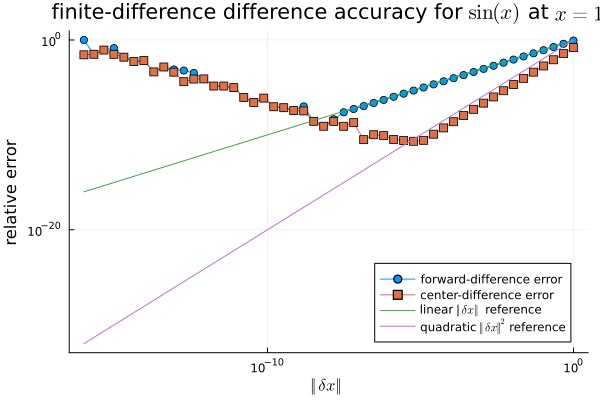

In [32]:
s = 10 .^ range(-16,0,50)
errors = [relative_error((sin(1+s)-sin(1))/s, cos(1)) for s in s]
plot(s, errors, xaxis=:log, yaxis=:log, markershape=:circle,
     title = L"finite-difference difference accuracy for $\sin(x)$ at $x=1$", xlabel=L"\Vert \delta x\Vert", ylabel="relative error",
     legend=:bottomright,
     label = "forward-difference error")

errors2 = [relative_error((sin(1+s)-sin(1-s))/2s, cos(1)) for s in s]
plot!(s, errors2, xaxis=:log, yaxis=:log, markershape=:square,
     label = "center-difference error")
plot!(s, s, label=L"linear $\Vert \delta x\Vert$ reference")
plot!(s, s.^2, label=L"quadratic $\Vert \delta x\Vert^2$ reference")

Indeed, the error goes down faster than before, so it turns out that our crude rule of thumb from before is not quite so good — the minimum error occurs around $10^{-5}$, not $10^{-8}$.

It's also instructive (though initially mystifying) to apply center-difference approximations to $f(X)=A^2$:

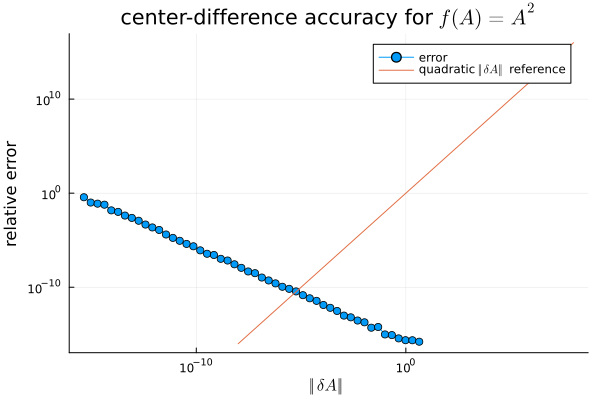

In [33]:
s = 10 .^ range(-8,8,50)
errors = [relative_error(f(A+s*dA)-f(A-s*dA), exact*2s) for s in s]
plot(s * norm(dA), errors, xaxis=:log, yaxis=:log, markershape=:circle,
     title = L"center-difference accuracy for $f(A)=A^2$", xlabel=L"\Vert \delta A\Vert", ylabel="relative error",
     label = "error")
plot!(s, s.^2, label=L"quadratic $\Vert \delta A\Vert$ reference")

Here, the error gets **worse monotonically** as you decrease $\delta A$!?!

The reason for this is that a center-difference formula is *exact* for quadratic functions, since
$$
(A+\delta A)^2 - (A-\delta A)^2 = 2[A \delta A + \delta A\, A]
$$
*exactly*.   So, the *only* error is the roundoff error, which increases with smaller $\delta A$.

One can go even further than this:

* You can derive higher-order finite-difference "stencil" formulas whose truncation error goes down even faster, at the expense of more function evaluations

* You can evaluate $f(x+\delta x)$ for smaller and smaller $\delta x$, fit to polynomials of higher and higher degree in $\delta x$, and *extrapolate* to $\delta x \to 0$.  You can even do this *adaptively* in order to determine when to stop shrinking $\delta x$ because roundoff errors are dominating.  A sophisticated version of this process is called [Richardson extrapolation](https://github.com/JuliaMath/Richardson.jl).

The [Julia FiniteDifferences.jl package](https://github.com/JuliaDiff/FiniteDifferences.jl) provides a large number of these techniques (both higher-order formulas and Richardson extrapolation techniques).

## Finite differences in higher dimensions

Higher-dimensional *inputs* $x$ pose a fundamental computational challenge for finite-difference techniques, because if you want to know what happens for **every possible direction δx** then we need **many finite differences** — one for **each dimensions of δx**.

For example, suppose $x \in \mathbb{R}^n$ ($n$-component column vector) and $f(x)$ is a scalar.  Then $f'(x) = (\nabla f)^T$ has **n components** $\partial f/\partial x_k$, and if you want to know the *whole gradient* then you need **n finite-differences**.

More generally, you need one finite difference for "each column" of the Jacobian.

The net result is that **finite difference in higher dimensions are expensive**: you have to evaluate $f(x)$ around $\sim n$ times in $n$ input dimensions.   This makes finite differences **impractical** for high-dimensional optimization (e.g. neural networks) where $n$ might be thousands or millions or (even billions).   

On the other hand, if you are just using finite differences as a *check*, it is usually sufficient to compute $f'(x) \delta x$ in a few **random directions**, i.e. for random small $\delta x$.

## Prefer analytical derivatives, with finite differences as a check

The upshot of all this is that you should **use analytical derivatives if at all possible**.  However, derivative computation is tricky, so finite differences are still incredibly useful as a check.

(Automatic differentiation is much less tricky and should generally give correct results.  But there are still many cases where AD fails or is inefficient, and has to be supplemented by hand-formulated derivatives for at least *part* of your calculation.)